# Coupled pendula

When I first moved into my office (23 years ago!) there was a really cool demo in there that I played with a lot. It had two identical weights tied to a string that ran horizontally between two supports. Those fishing weights could be set to oscillate like pendula. When you set just one going it would eventually transfer all of its energy over to the other one. This post is my attempt to model that. [Here's a great example of what I'm talking about.](https://www.youtube.com/watch?v=izy4a5erom8)



%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/izy4a5erom8" >
</iframe>

At first I tried to model the string as a bunch of masses with fixed distances between them, like I describe [in this post](https://arundquist.wordpress.com/2021/01/24/catenary-with-lagrange-multipliers/), but I was struggling to keep the Wolfram Engine happy. So instead I model the system as three springs tied end to end, with the far ends fixed in place. Then at the two junctions between the strings I hang pendula down. 

I have the natural lengths of the springs sum to the horizontal distance between the fixed points, and I put masses at those pivot points so that the whole "string" isn't just massless. I'm actually not sure if I needed to bother with that but it works so good enough.

One thing I found I had to do was put a lot of viscous friction on the points that make up the "string" but not on the points that make up the pendulum bobs. Basically the super strong springs created wild oscillations that I needed dampen to out, both to make it look realistic and to get the simulation to run faster.

In [ ]:
m=0.1; (* mass of the pivot points *)
M=1; (* mass of the pendulum bobs *)
r[i_][t_]:={x[i][t], y[i][t], z[i][t]};
r[0][t_]:={0,0,0}; (* one fixed point *)
r[3][t_]:={0,1,0}; (* the other fixed point *)
w[i_][t_]:=r[i][t]+0.25 {Sin[theta[i][t]] Cos[phi[i][t]], Sin[theta[i][t]] Sin[phi[i][t]], -Cos[theta[i][t]]}; (* equation for the location of the pendulum bobs *)
KE=1/2 m Total[Table[r[i]'[t].r[i]'[t], {i, 2}]]+1/2 M Total[Table[w[i]'[t].w[i]'[t], {i,2}]];
k=100000; (* super strong springs that make up the "string" *)
g=9.8;

(* the Potential Energy is a sum of the gravitational potential energy of
the pivot points, the gravitational potential energy of the pendulum bobs,
and the spring potential energy of the 3 springs that make up the "string" *)
PE=m g Total[Table[z[i][t], {i,2}]]+M g Total[Table[w[i][t][[3]], {i,2}]]+1/2 k Total[Table[(Sqrt[(r[i][t]-r[i-1][t]).(r[i][t]-r[i-1][t])]-1/3)^2, {i,1,3}]];
L=KE-PE;
beta=10; (* strength of the viscous friction *)
power=1/2 beta Total[Table[r[i]'[t].r[i]'[t], {i, 2}]]; (* how to do viscous friction in the Lagrangian formalism *)
el[a_]:=D[L, a[t]]-D[L, a'[t], t]-D[power,a'[t]]==0; (* the Euler-Lagrange equation for a generic generalized variable *)
sol0=First[NDSolve[{el/@Flatten[{Table[{x[i],y[i],z[i], theta[i], phi[i]}, {i,2}]}],
            Table[Thread[r[i][0]=={0,1/3 i, 0}], {i,2}], (* pivot points are equidistant *)
            Table[Thread[r[i]'[0]=={0,0,0}], {i,2}], (* pivot points start at rest *)
            Table[Thread[{theta[i][0],phi[i][0]}=={If[i==1,0.4,0.01],0}], {i,2}], (* first bob is lifted, second isn't. The phi angle needs to be zero for it to be the usual situation *)
            Table[Thread[{theta[i]'[0], phi[i]'[0]}=={0,0}], {i,2}]}, (* the pendulum bobs are started from rest *)
                Flatten[{Table[{x[i],y[i],z[i], theta[i], phi[i]}, {i,2}]}],
                {t,0,20}, (* you have to go out a while to see the transfer of energy *)
                Method->{"EquationSimplification"->"Residual"}]]; 

Here's a plot of the x component of both pendulum bobs. It's doesn't show perfect energy transfer, but I think that's because of how I'm doing the dampening.

In [ ]:
Plot[{w[1][t][[1]]/.sol0, w[2][t][[1]]/.sol0}, {t,0,20}]

Here's some code to generate an animation. I'm doing some trickery to slow down the default animation speed (for some reason the normal way to do that with ListAnimate isn't working in jupyter):

In [44]:
frame[t_]:=Show[Graphics3D[{PointSize[0.05],
            Red,
            Point[Table[r[i][t]/.sol, {i,2}]],
            Black,
            Line[Table[r[i][t]/.sol, {i,0,3}]],
            Table[Line[{r[i][t]/.sol, w[i][t]/.sol}], {i,2}],
            Green,
            Point[Table[w[i][t]/.sol,{i,2}]]}, PlotRange->{ {-.3,.3}, {-.1,1.1}, {-1,1.1}}]];

In [69]:
frameList=Table[frame[t],{t,0,20,.1}];
Export["C:\\Users\\arundquist\\AppData\\Local\\Programs\\Python\\Python311\\coupled_pendulum_zero.gif",frameList,"DisplayDurations"->0.1];

![image](coupled_pendulum_zero.gif)

And here's a parametric plot of the top view with the excited pendulum on the left:

In [ ]:
ParametricPlot[{w[1][t][[{2,1}]]/.sol0,w[2][t][[{2,1}]]/.sol0}, {t,0,20}]

## Only lateral coupling

Ok, that's working pretty well. What I'm really interested in modeling is something I noticed with the demo I had in my office so many years ago. If you start the first pendulum off at an angle (rather than pulling it in a direction perpendicular to the support string), the coupling really only works in the direction perpendicular to the string and so only that motion gets excited. The first pendulum bob coughs up some energy that makes the second one move perpendicular to the string, but the first one starts to move in cool ways. Let's see if I can model that. Really I just have to change the initial condition on `phi` or the 4th line below:

In [71]:
sol=First[NDSolve[{el/@Flatten[{Table[{x[i],y[i],z[i], theta[i], phi[i]}, {i,2}]}],
            Table[Thread[r[i][0]=={0,1/3 i, 0}], {i,2}], (* pivot points are equidistant *)
            Table[Thread[r[i]'[0]=={0,0,0}], {i,2}], (* pivot points start at rest *)
            Table[Thread[{theta[i][0],phi[i][0]}=={If[i==1,0.4,0.01],Pi/4}], {i,2}], (* first bob is lifted, second isn't. The phi angle needs to be zero for it to be the usual situation *)
            Table[Thread[{theta[i]'[0], phi[i]'[0]}=={0,0}], {i,2}]}, (* the pendulum bobs are started from rest *)
                Flatten[{Table[{x[i],y[i],z[i], theta[i], phi[i]}, {i,2}]}],
                {t,0,20}, (* you have to go out a while to see the transfer of energy *)
                Method->{"EquationSimplification"->"Residual"}]];

Here's the plot of just the x-component (that's perpendicular to the string)

-Graphics-
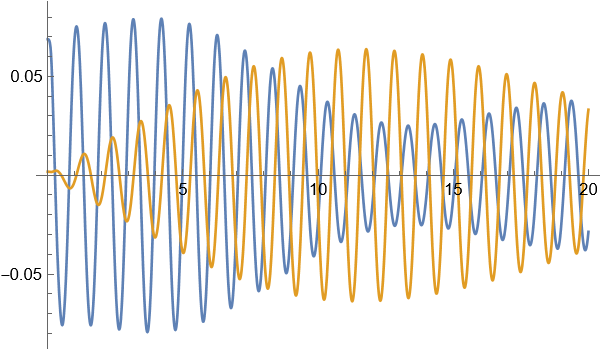

In [72]:
Plot[{w[1][t][[1]]/.sol, w[2][t][[1]]/.sol}, {t,0,20}]

See how it's a much worse coupling? It's much better to look at the parametric plot:

-Graphics-
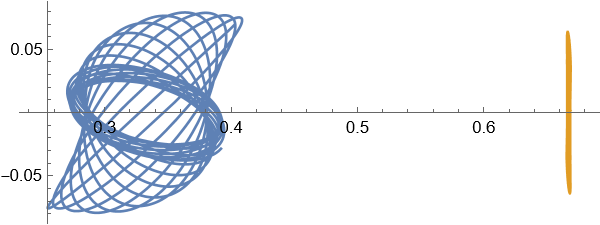

In [73]:
ParametricPlot[{w[1][t][[{2,1}]]/.sol,w[2][t][[{2,1}]]/.sol}, {t,0,20}]

In [74]:
frameList2=Table[frame[t],{t,0,20,.1}];
Export["C:\\Users\\arundquist\\AppData\\Local\\Programs\\Python\\Python311\\coupled_pendulum_45_deg.gif",frameList2,"DisplayDurations"->0.1];

![image](coupled_pendulum_45_deg.gif)

It works! It's basically just as I remember it. This partial coupling is really interesting, I think.

## Your thoughts?

I've love to hear what you think about this. Here are some starters for you:

1. This is cool. My favorite part is . . .
2. This is dumb. I'm especially frustrated by . . .
3. Wait, it looks like the parametric plot is mirrored from what's happening in the animation. What's up with that?
4. Red and green? What is this, christmas?
5. I just built one of these and there's another cool thing I've noticed . . .
6. Ah, typical physicist. "It works so good enough" should go on your tombstone.
7. I know why you're not seeing perfect energy transfer. It's because . . .